In [1]:
# !pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=a1a61dec47a8697dd0bc1436e9e617da3c73ef7f112be69ca0b33825183381f3
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [1]:
import os
import shutil
import zipfile
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
from torchvision import models
import time
import tqdm
import os

from torchvision.models import mobilenet_v3_small, mobilenet_v3_large
from efficientnet_pytorch import EfficientNet

### 로컬환경에서 이미지 압축파일을 업로드 하기위한 코드

In [8]:
# from IPython.display import display
# from ipywidgets import FileUpload

# upload_widget = FileUpload()
# display(upload_widget)

# # 선택한 파일을 확인하려면 아래 코드를 실행하세요.
# # upload_widget.value는 딕셔너리 형태로 업로드된 파일을 반환합니다.
# for filename in upload_widget.value:
#     print(f"Uploaded file: {filename}")

# # zip 파일도 여기서 업로드할 수 있는지 확인하자

FileUpload(value=(), description='Upload')

In [3]:
print(os.getcwd())

c:\Users\user\Image_classifier_Model


#### 1. 이미 압축이 해제되어 있다면 압축풀기 하지않고 넘어감 
#### 2. 압축폴더안의 파일이 모두 있으면(손상되거나 분실된 것이 없다면) 넘어감
#### 3. 만약 하나라도 손상된 파일이 있으면 모두 삭제하고 재 압축해제 

In [14]:
import os
import zipfile
import shutil

def count_files_in_dir(directory):
    """디렉토리 내의 파일 개수를 세는 함수"""
    total_files = 0
    for root, dirs, files in os.walk(directory):
        total_files += len(files)
    return total_files

def extract_zip_if_needed(zip_path, extract_path, expected_file_count):
    """압축 파일을 풀기 전에 파일 수를 확인하고, 파일이 부족하면 재압축 해제"""
    if os.path.exists(extract_path):
        current_file_count = count_files_in_dir(extract_path)
        if current_file_count == expected_file_count:
            print(f"{extract_path} already has {current_file_count} files. Skipping extraction.")
            return
        else:
            print(f"{extract_path} has {current_file_count} files, expected {expected_file_count}. Re-extracting.")
            shutil.rmtree(extract_path)  # 폴더 삭제
    else:
        print(f"{extract_path} does not exist. Extracting...")

    os.makedirs(extract_path, exist_ok=True)  # 압축 풀 디렉토리 생성
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Extracted {zip_path} to {extract_path}.")

# 데이터 경로 설정
base_dir = os.getcwd()  # 현재 작업 디렉토리
data_dir = os.path.join(base_dir, 'data')  # 'data' 폴더 생성
dog_vs_cat_zip = os.path.join(base_dir, 'dogs-vs-cats.zip')  # dogs-vs-cats.zip 파일 경로

# 1. dogs-vs-cats.zip 파일 압축 풀기
if os.path.exists(dog_vs_cat_zip):
    print(f"Extracting {dog_vs_cat_zip}...")
    with zipfile.ZipFile(dog_vs_cat_zip, 'r') as zip_ref:
        zip_ref.extractall(data_dir)
    print(f"{dog_vs_cat_zip} extracted successfully!")
else:
    print(f"{dog_vs_cat_zip} not found.")
    
# 압축 해제된 'train.zip'과 'test1.zip' 파일 경로 설정
train_data_zip = os.path.join(data_dir, 'train.zip')
test_data_zip = os.path.join(data_dir, 'test1.zip')

# 압축 해제할 디렉토리 경로 설정
train_extract_path = os.path.join(data_dir, 'train')
test_extract_path = os.path.join(data_dir, 'test1')

# 예상 파일 수 설정 (압축 파일 내부에 실제 파일 수에 맞게 설정)
expected_train_files = 25000  # train.zip 내부의 이미지 파일 수
expected_test_files = 12500  # test1.zip 내부의 이미지 파일 수

# train.zip 압축 풀기
if os.path.exists(train_data_zip):
    extract_zip_if_needed(train_data_zip, train_extract_path, expected_train_files)
else:
    print(f"{train_data_zip} not found.")

# test1.zip 압축 풀기
if os.path.exists(test_data_zip):
    extract_zip_if_needed(test_data_zip, test_extract_path, expected_test_files)
else:
    print(f"{test_data_zip} not found.")

Extracting c:\Users\user\Image_classifier_Model\dogs-vs-cats.zip...
c:\Users\user\Image_classifier_Model\dogs-vs-cats.zip extracted successfully!
c:\Users\user\Image_classifier_Model\data\train already has 25000 files. Skipping extraction.
c:\Users\user\Image_classifier_Model\data\test1 already has 12500 files. Skipping extraction.


In [16]:
import os

# 현재 작업 디렉토리 확인
print("현재 작업 디렉토리:", os.getcwd())

현재 작업 디렉토리: /content


#### 분리된 데이터를 담아둘 폴더 경로설정 및 생성

In [7]:
# 폴더명(경로)
sdata = 'sdata'
train_sdata = os.path.join(sdata, 'train')
valid_sdata = os.path.join(sdata, 'valid')
test_sdata = os.path.join(sdata, 'test')

# 폴더만들기
os.makedirs(train_sdata, exist_ok=True)
os.makedirs(valid_sdata, exist_ok=True)
os.makedirs(test_sdata, exist_ok=True)

# 하위 폴더 만들기(train)
train_sdata_dog = os.path.join(train_sdata, 'dog')
train_sdata_cat = os.path.join(train_sdata, 'cat')
os.makedirs(train_sdata_dog, exist_ok=True)
os.makedirs(train_sdata_cat, exist_ok=True)


# 하위 폴더 만들기(valid)
valid_sdata_dog = os.path.join(valid_sdata, 'dog')
valid_sdata_cat = os.path.join(valid_sdata, 'cat')
os.makedirs(valid_sdata_dog, exist_ok=True)
os.makedirs(valid_sdata_cat, exist_ok=True)


In [16]:
# 존재한다면 리스트로 만들어주기

dogList = []
catList = []

for i in range(2000):
    dogList.append('dog.'+str(i)+'.jpg')
    catList.append('cat.'+str(i)+'.jpg')

In [17]:
print(dogList)
print(catList)

['dog.0.jpg', 'dog.1.jpg', 'dog.2.jpg', 'dog.3.jpg', 'dog.4.jpg', 'dog.5.jpg', 'dog.6.jpg', 'dog.7.jpg', 'dog.8.jpg', 'dog.9.jpg', 'dog.10.jpg', 'dog.11.jpg', 'dog.12.jpg', 'dog.13.jpg', 'dog.14.jpg', 'dog.15.jpg', 'dog.16.jpg', 'dog.17.jpg', 'dog.18.jpg', 'dog.19.jpg', 'dog.20.jpg', 'dog.21.jpg', 'dog.22.jpg', 'dog.23.jpg', 'dog.24.jpg', 'dog.25.jpg', 'dog.26.jpg', 'dog.27.jpg', 'dog.28.jpg', 'dog.29.jpg', 'dog.30.jpg', 'dog.31.jpg', 'dog.32.jpg', 'dog.33.jpg', 'dog.34.jpg', 'dog.35.jpg', 'dog.36.jpg', 'dog.37.jpg', 'dog.38.jpg', 'dog.39.jpg', 'dog.40.jpg', 'dog.41.jpg', 'dog.42.jpg', 'dog.43.jpg', 'dog.44.jpg', 'dog.45.jpg', 'dog.46.jpg', 'dog.47.jpg', 'dog.48.jpg', 'dog.49.jpg', 'dog.50.jpg', 'dog.51.jpg', 'dog.52.jpg', 'dog.53.jpg', 'dog.54.jpg', 'dog.55.jpg', 'dog.56.jpg', 'dog.57.jpg', 'dog.58.jpg', 'dog.59.jpg', 'dog.60.jpg', 'dog.61.jpg', 'dog.62.jpg', 'dog.63.jpg', 'dog.64.jpg', 'dog.65.jpg', 'dog.66.jpg', 'dog.67.jpg', 'dog.68.jpg', 'dog.69.jpg', 'dog.70.jpg', 'dog.71.jpg', '

### train/valid/test split 일반화

In [10]:
# 데이터셋의 총 개수를 인자로 받아 비율에 따라 분할
def split_data(total_num, train_ratio=0.8, valid_ratio=0.1, test_ratio=0.1):
    # 비율의 합이 1인지 확인
    assert train_ratio + valid_ratio + test_ratio == 1.0, "비율의 합은 1이어야 합니다."

    # 각 데이터셋의 개수 계산
    train_num = int(total_num * train_ratio)
    valid_num = int(total_num * valid_ratio)
    test_num = total_num - train_num - valid_num  # 남은 데이터를 테스트셋으로

    # 각 데이터셋의 범위 계산
    train_range = [0, train_num - 1]
    valid_range = [train_num, train_num + valid_num - 1]
    test_range = [train_num + valid_num, total_num - 1]

    return train_range, valid_range, test_range

# 예시: 총 데이터 개수가 12500일 경우
total_num = 12500
train_range, valid_range, test_range = split_data(total_num)

print(f"Train range: {train_range}")
print(f"Valid range: {valid_range}")
print(f"Test range: {test_range}")

Train range: [0, 9999]
Valid range: [10000, 11249]
Test range: [11250, 12499]


#### test 데이터를 더이상 train data에서 split 하지 않고 기존 testdata에서 가져오고 싶으면 복사할때 경로만 수정해주면 된다.

In [13]:
import os
import shutil

# 데이터셋 디렉토리 경로 설정 (데이터셋이 저장된 경로로 수정하세요)
# train_dataset_dir = 'train'
# test_data_dir = 'test1'
# test = 'sdata/test'
dataset_dir = 'data/train'
test_dataset_dir = 'data/test1'

# 새로운 train, valid, test 디렉토리 생성 경로
base_dir = 'sdata'

# 클래스 목록
classes = ['dog', 'cat']

# 폴더 경로 생성
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# 폴더 생성 함수
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

# train, valid, test 폴더 및 각각의 클래스 폴더 생성
for cls in classes:
    create_dir(os.path.join(train_dir, cls))
    create_dir(os.path.join(valid_dir, cls))
    create_dir(os.path.join(test_dir))

# 이미지 복사 함수
def copy_images(start_idx, end_idx, src_dir, dst_dir, label):
    for i in range(start_idx, end_idx + 1):
        file_name = f'{label}.{i}.jpg'
        src_path = os.path.join(src_dir, file_name)
        dst_path = os.path.join(dst_dir, file_name)
        if os.path.exists(src_path):
            # print(f"Copying {src_path} to {dst_path}")
            shutil.copy(src_path, dst_path)
        # else:
            # print(f"File not found: {src_path}")

# 클래스별로 train, valid, test 데이터셋 구성
for cls in classes:
    # train dataset 구성
    copy_images(train_range[0], train_range[1], dataset_dir, os.path.join(train_dir, cls), cls)

    # valid dataset 구성
    copy_images(valid_range[0], valid_range[1], dataset_dir, os.path.join(valid_dir, cls), cls)

    # test dataset 구성(train dataset에서 test data 분할한 경우)
    copy_images(test_range[0], test_range[1], dataset_dir, os.path.join(test_dir), cls)

# # test dataset 구성 (진짜 test 폴더의 모든 파일 복사)
# test_files = os.listdir(test_dataset_dir)

# # test_files에서 0번째부터 1249번째 파일만 선택
# for idx, file_name in enumerate(test_files):
#     src_path = os.path.join(test_dataset_dir, file_name)
#     dst_path = os.path.join(test_dir, file_name)

#     if os.path.exists(src_path):
#         shutil.copy(src_path, dst_path)
#     else:
#         print(f"File not found: {src_path}")
print("데이터셋 분할 및 복사가 완료되었습니다.")

데이터셋 분할 및 복사가 완료되었습니다.


In [18]:
test_dir

'sdata\\test'

In [19]:
test = 'sdata/test'
file_list = os.listdir(test_dir)
print(f"파일 개수: {len(file_list)}")

파일 개수: 2500


In [21]:
train_cat = os.listdir(os.path.join(train_dir,'cat'))
train_dog = os.listdir(os.path.join(train_dir,'dog'))
valid_cat = os.listdir(os.path.join(valid_dir,'cat'))
valid_dog = os.listdir(os.path.join(valid_dir,'dog'))
test = os.listdir(test_dir)

In [22]:
len(train_cat), len(train_dog), len(valid_cat), len(valid_dog), len(test)

(10000, 10000, 1250, 1250, 2500)

### 테스트 데이터에 따른 2가지 커스텀 데이터셋 정의

레이블이 없는 테스트 데이터 가져올때

In [29]:
# # # 4. Custom Dataset 정의
# class customDataset(Dataset):
#     def __init__(self, files, root_dir, mode, transform=None):
#         self.files = files
#         self.root_dir = root_dir
#         self.mode = mode
#         self.transform = transform

#     def __len__(self):
#         return len(self.files)

#     def __getitem__(self, idx):
#         img_path = os.path.join(self.root_dir, self.files[idx])
#         img = Image.open(img_path)

#         # 레이블 설정: 파일명에 따라 동적으로 레이블 설정
#         if 'dog' in self.files[idx]:
#             label = 1
#         else:
#             label = 0

#         if self.transform:
#             img = self.transform(img)

#         # 'train' 모드일 때는 이미지와 레이블만 반환
#         if self.mode == 'train':
#             return img, np.array([label])

#         # 'test' 모드일 때는 이미지, 레이블, 파일 이름을 반환
#         else:
#             return img, self.files[idx]

train data에서 test data까지 split 했다면 test data에도 lable이 존재하므로 아래의 코드를 활용가능

In [23]:
class customDataset(Dataset):
    def __init__(self, files, root_dir, mode, transform=None):
        self.files = files
        self.root_dir = root_dir
        self.mode = mode
        self.transform = transform

        # 레이블 생성 cat=0, dog=1
        if 'dog' in files[0]:
            self.label = 1
        else:
            self.label = 0
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.files[idx])
        img = Image.open(img_path)

        if self.transform:
            img = self.transform(img)

        if self.mode == 'train':
            return img, np.array([self.label])

        else:
            if self.files[idx].split('.')[0]=='dog':
                self.label = 1
            else:
                self.label = 0
            return img, np.array([self.label]), self.files[idx]

#### 이미지 전처리

In [24]:
# 5. 이미지 전처리 설정
org_size = (256, 256)
img_size = 224
visual_transform = transforms.Compose([
    transforms.Resize(org_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(img_size),
    # 평균이 0.5 표준편차 0.5 (0~1사이의 실수)
    transforms.ToTensor(),
    ])
train_transform = transforms.Compose([
    transforms.Resize(org_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

test_transform = transforms.Compose([
    transforms.Resize(org_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

#### 데이터셋 인스턴스화

In [25]:
# 데이터셋 인스턴스화

# 인수값 : 파일목록, 파일경로, 모드, transforms


visual_dog_dataset = customDataset(train_dog, os.path.join(train_dir, 'dog'), 'train', transform=visual_transform)
visual_cat_dataset = customDataset(train_cat, os.path.join(train_dir, 'cat'), 'train', transform=visual_transform)

train_dog_dataset = customDataset(train_dog, os.path.join(train_dir,'dog'), 'train', transform = train_transform)
train_cat_dataset = customDataset(train_cat, os.path.join(train_dir,'cat'), 'train', transform = train_transform)

# valid 데이터도 레이블이 필요하기 때문에 train 모드로 받아와야 함
valid_dog_dataset = customDataset(valid_dog, os.path.join(valid_dir,'dog'), 'train', transform = train_transform)
valid_cat_dataset = customDataset(valid_cat, os.path.join(valid_dir,'cat'), 'train', transform = train_transform)

# 테스트데이터 가져오기
test_dataset = customDataset(test, os.path.join(test_dir), 'test', transform = test_transform)


from torch.utils.data import ConcatDataset
visual_dataset = ConcatDataset([visual_dog_dataset, visual_cat_dataset])
train_dataset = ConcatDataset([train_dog_dataset, train_cat_dataset])
valid_dataset = ConcatDataset([valid_dog_dataset, valid_cat_dataset])


#### 데이터로더 인스턴스화

In [26]:
# 데이터로더 객체생성

from torch.utils.data import DataLoader

batch_size = 32
visual_loader = DataLoader(visual_dataset, batch_size=batch_size, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

#### 가져올 데이터 시각화

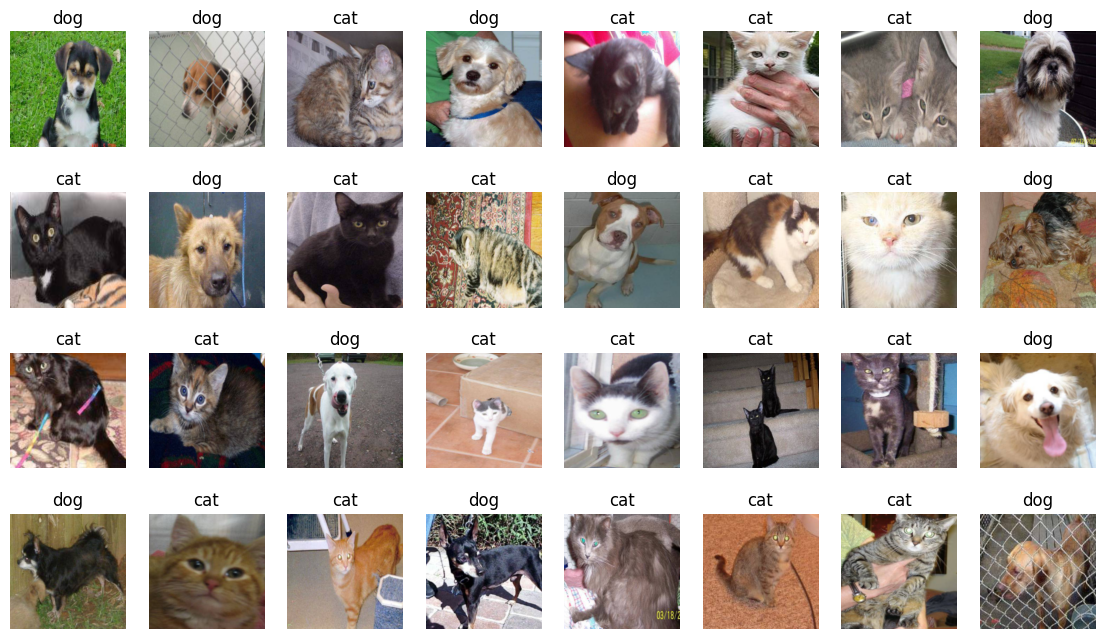

In [28]:
import matplotlib.pyplot as plt

# 배치사이즈만큼의 이미지를 시각화함함
images, labels = next(iter(visual_loader))

classes ={0:'cat',1:'dog'}

fig = plt.figure(figsize=(14, 8))
for i in range(batch_size):
    # 4행 8열
    ax = fig.add_subplot(4, 8, i + 1)
    ax.set_title(classes[labels[i].item()])
    ax.axis('off')
    # 컬러 채널 순서를 재정렬
    ax.imshow(images[i].permute(1, 2, 0))

plt.show()

#### 모델 정의 및 설정

In [39]:
import torch
import torch.nn as nn
import torchvision
from efficientnet_pytorch import EfficientNet

# device 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# He 초기화를 적용하는 함수 정의
def initialize_weights_he(module):
    if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
        torch.nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
        if module.bias is not None:
            torch.nn.init.zeros_(module.bias)

# 모델 정의 및 수정
def create_model(model_name):
    """모델 생성 및 수정"""
    if model_name == 'efficientNetB2':
        model = EfficientNet.from_pretrained('efficientnet-b2')
    elif model_name == 'efficientNetB0':
        model = EfficientNet.from_pretrained('efficientnet-b0')
    elif model_name == 'MNV3_large':
        model = torchvision.models.mobilenet_v3_large(pretrained=True)
    elif model_name == 'MNV3_small':
        model = torchvision.models.mobilenet_v3_small(pretrained=True)
    elif model_name == 'RESNET50':
        model = torchvision.models.resnet50(pretrained=True)
    else:
        raise ValueError(f"Model '{model_name}' not recognized.")
    
    # GPU로 모델 이동
    model = model.to(device)

    # 모델에 따라 마지막 레이어 수정
    if model_name in ['efficientNetB2', 'efficientNetB0']:
        # EfficientNet 모델의 마지막 레이어 수정
        num_features = model._fc.in_features
        model._fc = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            nn.Sigmoid()  # 이진 분류용 Sigmoid
        ).to(device)
        # He 초기화 적용
        model._fc.apply(initialize_weights_he)
    
    elif model_name in ['MNV3_large', 'MNV3_small']:
        # MobileNet V3의 마지막 레이어 수정
        num_features = model.classifier[0].in_features
        model.classifier = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            nn.Sigmoid()
        ).to(device)
        # He 초기화 적용
        model.classifier.apply(initialize_weights_he)
    
    elif model_name == 'RESNET50':
        # ResNet의 마지막 레이어 수정
        num_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            nn.Sigmoid()
        ).to(device)
        # He 초기화 적용
        model.fc.apply(initialize_weights_he)

    return model

# 선택 가능한 모델 출력
models = ['efficientNetB2', 'efficientNetB0', 'MNV3_large', 'MNV3_small', 'RESNET50']
print("사용 가능한 모델:")
for model_name in models:
    print(f" - {model_name}")

# 모델 선택
selected_model_name = "MNV3_small"  # 선택하려는 모델 이름

# 모델 생성
model = create_model(selected_model_name)
print(f"선택된 모델: {selected_model_name}")

사용 가능한 모델:
 - efficientNetB2
 - efficientNetB0
 - MNV3_large
 - MNV3_small
 - RESNET50
선택된 모델: MNV3_small


In [41]:
from torchsummary import summary
summary(model, input_size = (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 257, 257]               0
Conv2dStaticSamePadding-2         [-1, 32, 128, 128]             864
       BatchNorm2d-3         [-1, 32, 128, 128]              64
MemoryEfficientSwish-4         [-1, 32, 128, 128]               0
         ZeroPad2d-5         [-1, 32, 130, 130]               0
Conv2dStaticSamePadding-6         [-1, 32, 128, 128]             288
       BatchNorm2d-7         [-1, 32, 128, 128]              64
MemoryEfficientSwish-8         [-1, 32, 128, 128]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 32, 1, 1]             288
         I

#### 손실함수 및 옵티마이저 정의(하이퍼파라미터 튜닝)

In [31]:
# 7. 손실함수 및 옵티마이저 정의
lr = 0.00001
epochs = 15
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = 0.0005)

#### fit 함수 정의

In [32]:
import time
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

def imshow(img):
    # 이미지 정규화를 해제하기 위해 역변환
    img = img / 2 + 0.5  # (0.5, 0.5, 0.5)로 정규화된 이미지일 경우
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

def fit(model, criterion, optimizer, epochs, train_loader, valid_loader):
    model.train()

    train_loss = 0
    train_acc = 0
    train_correct = 0

    # 그래프를 출력하기 위해 리스트에 누적
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []

    # 잘못 예측된 이미지를 저장할 리스트
    wrong_images = []
    wrong_labels = []
    wrong_preds = []

    for epoch in range(epochs):
        start = time.time()

        # tqdm을 사용하여 각 에포크의 진행률 표시
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)

        # 1 epoch 중에 train에 해당하는 for 문
        for train_x, train_y in train_loader_tqdm:
            model.train()
            train_x, train_y = train_x.to(device), train_y.to(device).float()
            # 기울기 초기화
            optimizer.zero_grad()
            # 예측
            pred = model(train_x)
            # 손실계산
            loss = criterion(pred, train_y)
            # 오차역전파
            loss.backward()
            # 진행
            optimizer.step()
            train_loss += loss.item()

            # sigmoid
            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            # y_pred와 train_y값이 같으면 train_correct 추가
            train_correct += y_pred.eq(train_y.cpu()).int().sum()

        # validation data check
        valid_loss = 0
        valid_acc = 0
        valid_correct = 0

        # tqdm을 사용하여 각 에포크의 validation 진행률 표시
        valid_loader_tqdm = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=False)

        # 1 epoch 중에 validation에 해당하는 for 문
        for valid_x, valid_y in valid_loader_tqdm:
            with torch.no_grad():
                model.eval()
                # print(f'valid_x : {valid_x}')
                # print(f'type(valid_x) : {type(valid_x)}')
                # print(f'valid_y : {valid_y}')
                # print(f'type(valid_y) : {type(valid_y)}')
                valid_x, valid_y = valid_x.to(device), valid_y.to(device).float()
                pred = model(valid_x)
                loss = criterion(pred, valid_y)
            valid_loss += loss.item()

            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            valid_correct += y_pred.eq(valid_y.cpu()).int().sum()

            # 잘못 예측한 이미지와 레이블 저장
            wrong_idx = (y_pred != valid_y.cpu()).nonzero(as_tuple=True)[0]
            for idx in wrong_idx:
                wrong_images.append(valid_x.cpu()[idx])  # 잘못 예측된 이미지
                wrong_labels.append(valid_y.cpu()[idx])  # 실제 라벨
                wrong_preds.append(y_pred[idx])          # 예측된 값

        train_acc = train_correct / len(train_loader.dataset)
        valid_acc = valid_correct / len(valid_loader.dataset)

        print(f'{time.time() - start:.3f}sec : [Epoch {epoch+1}/{epochs}] -> train loss: {train_loss/len(train_loader):.4f}, train acc: {train_acc*100:.3f}% / valid loss: {valid_loss/len(valid_loader):.4f}, valid acc: {valid_acc*100:.3f}%')

        train_losses.append(train_loss/len(train_loader))
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss/len(valid_loader))
        valid_accuracies.append(valid_acc)

        train_loss = 0
        train_acc = 0
        train_correct = 0

    # 잘못 예측한 이미지를 시각화
    print(f"잘못 예측한 이미지 수: {len(wrong_images)}")

    # 최대 5개의 잘못 예측된 이미지를 시각화
    for i in range(min(5, len(wrong_images))):
        print(f"실제 라벨: {wrong_labels[i].item()}, 예측값: {wrong_preds[i].item()}")
        imshow(wrong_images[i])

    # 학습 및 검증 손실/정확도 시각화
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Valid Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(valid_accuracies, label='Valid Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.show()


아래의 코드는 테스트 데이터를 평가하고 시각화하는 함수인데    
레이블이 잇는 테스트 데이터에 한해서 정확도 측정이 가능하다(EX - 레이블이 존재하는 트레인데이터셋에서 테스트 데이터를 분할한 경우)

현재 레이블이 없는 실제 테스트 데이터를 활용할 예정이므로    
시각화를 통해 테스트 데이터를 어떤 레이블로 예측했는지 확인하는 코드를 사용할 예정

In [33]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
import os
from tqdm import tqdm

# 테스트 데이터에서 성능을 평가하고, 예측이 잘못된 이미지를 시각화하는 함수
def evaluate_and_visualize(model, test_loader, criterion):
    test_loss = 0
    test_correct = 0
    test_total = 0
    incorrect_labels = []
    incorrect_preds = []
    incorrect_filenames = []

    model.eval()
    with torch.no_grad():
        for test_x, test_y, filenames in tqdm(test_loader):
            test_x, test_y = test_x.to(device), test_y.to(device).float()
            pred = model(test_x)
            loss = criterion(pred, test_y)
            test_loss += loss.item()

            # 예측 결과 처리
            y_pred = pred.cpu()
            y_pred = (y_pred >= 0.5).float()

            # 정확도 계산
            test_correct += y_pred.eq(test_y.cpu()).int().sum()
            test_total += test_y.size(0)

            # 잘못된 예측 저장 (각 요소별로 비교)
            for i in range(len(y_pred)):
                if y_pred[i] != test_y.cpu()[i]:  # 예측과 실제가 다른 경우에만 저장
                    incorrect_labels.append(test_y.cpu()[i].numpy())
                    incorrect_preds.append(y_pred[i].numpy())
                    incorrect_filenames.append(filenames[i])

    test_accuracy = test_correct / test_total
    print(f"test_correct:{test_correct}, test_total:{test_total}")
    print(f'Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy * 100:.2f}%')

    # 예측이 잘못된 이미지 시각화
    fig = plt.figure(figsize=(12, 12))
    for i in range(min(16, len(incorrect_filenames))):
        ax = fig.add_subplot(4, 4, i + 1)
        image = Image.open(os.path.join('sdata/test', incorrect_filenames[i]))
        ax.imshow(image)
        true_label = 'dog' if incorrect_labels[i] == 1 else 'cat'
        pred_label = 'dog' if incorrect_preds[i] == 1 else 'cat'
        ax.set_title(f'Pred: {pred_label}, Label: {true_label}, {incorrect_filenames[i]}', fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

#### 실제 테스트 데이터에 대한 결과 시각화하는 함수

In [45]:
#테스트 데이터를 어떻게 예측했는지 샘플 뽑아보기(일단 10개)
def visualize_predictions(model, test_loader, device, num_images=10):
    model.eval()  # 평가 모드로 전환
    count = 0  # 시각화한 이미지 개수를 세기 위한 변수
    with torch.no_grad():
        for test_x, filenames in test_loader:
            test_x = test_x.to(device)
            outputs = model(test_x)
            predictions = (outputs > 0.5).float()  # 시그모이드 출력으로 예측
            for i in range(test_x.size(0)):  # 배치 내 각 이미지에 대해
                if count >= num_images:  # 원하는 이미지 개수만 시각화
                    return
                img = test_x[i].cpu().permute(1, 2, 0).numpy()  # 이미지 형태 변환
                predicted_label = "Dog" if predictions[i].item() == 1 else "Cat"
                filename = filenames[i]

                # 이미지와 파일 이름, 예측 결과 시각화
                plt.imshow(img)
                plt.title(f"File: {filename}, Predicted: {predicted_label}")
                plt.axis('off')  # 축 제거
                plt.show()

                count += 1  # 시각화한 이미지 개수 증가


In [46]:
import torch
print(torch.__version__)

print(torch.version.cuda)

2.4.1+cu121
12.1


#### 학습

In [34]:
# 9. 모델 학습
fit(model, criterion, optimizer, epochs, train_loader, valid_loader)


KeyboardInterrupt: 

In [ ]:
# 테스트 데이터를 통해 성능 평가 및 잘못된 예측 시각화
# 테스트 데이터에 레이블이 있는 경우
evaluate_and_visualize(model, test_loader, criterion)

In [ ]:
# 레이블 없는 테스트 데이터에 대한 시각화 실행
# visualize_predictions(model, test_loader, device)